## train 3D UNet on single molecule dataset

### load data

In [1]:
import os 
import numpy as np
from dataGenerator import imageLoader
import keras
import matplotlib.pyplot as plt
import glob
import random

In [2]:
# visualize

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    plt.title('GT slice')
    plt.show()

In [3]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

240


In [4]:
print('image list:', train_img_list[10])
print('mask list:', train_msk_list[10])

image list: E:/EM/demo/3D_Unet_keras/inputData/train/images\image_110.npy
mask list: E:/EM/demo/3D_Unet_keras/inputData/train/masks\mask_110.npy


In [5]:
# visualize the images

img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)



image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


In [6]:
#  change the data into one channel

# test = np.vstack([test_mask], axis=3)
test = np.expand_dims(test_mask, axis = -1)
print(test.shape)

(64, 64, 64, 1)


current slice: 32


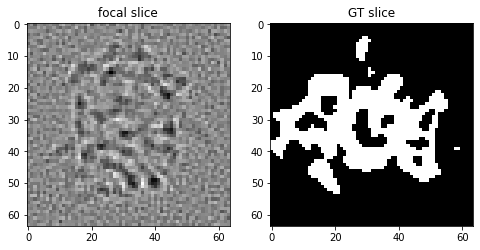

In [7]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 32
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

current slice: 48


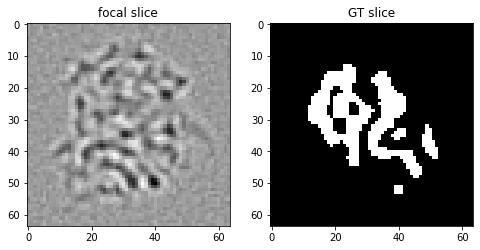

In [8]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 48
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

### calculate the weight between labels. useful for weighted dice loss

In [9]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [10]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.56 4.4


### define the image generator

In [11]:
# data path

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/inputData/'

# training
train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

# train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
# train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

train_img_list = os.listdir(train_img_dir)
train_msk_list = os.listdir(train_msk_dir)

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

# val_img_list = sorted(glob.glob(val_img_dir + '/*.npy'))
# val_msk_list = sorted(glob.glob(val_msk_dir + '/*.npy'))
val_img_list = os.listdir(val_img_dir)
val_msk_list = os.listdir(val_msk_dir)

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

# test_img_list = sorted(glob.glob(test_img_dir + '/*.npy'))
# test_msk_list = sorted(glob.glob(test_msk_dir + '/*.npy'))

test_img_list = os.listdir(test_img_dir)
test_msk_list = os.listdir(test_msk_dir)

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 240
val images: 30
test images: 30


In [12]:
# data generator for training

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)

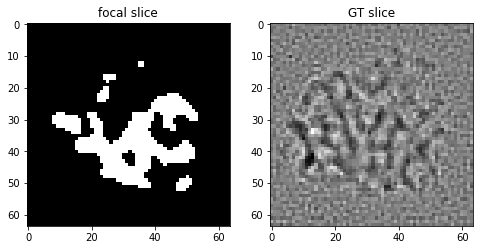

In [13]:
# visualize the data generator

img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0]-1)
test_img = img[img_num][...,0]
test_mask = msk[img_num] # whcih stack
test_mask = np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 32
visusalizeIMG(n_slice, test_mask, test_img)

### define the loss, metrics and optimizer for training

In [14]:
# wt0, wt1 = 0.5,0.5
wt0, wt1 = 0.56,4.4

import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))  # default is uniform
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1* focal_loss)  # works for most segmentation jobs


metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [15]:
# loss G.

import tensorflow as tf
import tensorflow.keras.backend as K

LR = 0.0001
optim = keras.optimizers.Adam(LR)
# soft dice
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def loss_function(y_true, y_pred):
    dice_loss = -dice_coef(y_true, y_pred)
    l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))
    # BCE = tf.keras.losses.BinaryCrossentropy()
    # CE_loss = BCE(y_true, y_pred).numpy()
    
    SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    print('SCE shape:', SCE.shape)
    
    # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
    total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE, axis=(1,2))*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
    return total_loss
    

### fit the model

In [16]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [17]:
# # load model from transfer learning

# from simple3DUnet import simple_unet_model

# model = simple_unet_model(IMG_HEIGHT=64,
#                          IMG_WIDTH=64,
#                          IMG_DEPTH=64,
#                          IMG_CHANNELS=1,
#                          num_classes=1)   # change the num; 2->1. G.

# # model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# # print(model.summary())
# print(model.input_shape)
# print(model.output_shape)

In [18]:
# from tensorflow.keras.models import Model

In [19]:
# G's model
# import tensorflow as tf
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
# import tensorflow.keras.backend as K
# from tensorflow_addons.layers import InstanceNormalization

# from Unet_G import UNet
from Unet_G import *

# shape, out_channels=3, inputs=None, full_model=False, z_enc=None
model = UNet((64,64,64), out_channels=64, full_model=True)   # change the num; 2->1. G.

# model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# print(model.summary())
print(model.input_shape)
print(model.output_shape)

(None, 64, 64, 64)
(None, 64, 64, 64)


### train and save model

In [20]:
# # not use the fit. G. // train_on_batch
# don't use the fit, use this way for 

# # NUM_STEPS = 100000

# NUM_STEPS = 5000

# # model.summary()

# for step in range(NUM_STEPS):
    
#     img, msk = train_img_datagen.__next__()
    
#     msk = np.argmax(msk, axis=-1)  # remove last channel
#     msk = np.expand_dims(msk, axis=-1).astype('float64')
    
#     # plt.imshow(img[0,32,:,:,0], cmap='gray')
#     # plt.show()
#     # model.summary()
    
#     loss = model.train_on_batch(img, msk)
    
#     # print(step, loss)
    
#     if step % 1000 == 0:
#         model.save_weights('./model_savedG.hdf5')
        
#     if step % 100 == 0:
#         prediction = model.predict(img,batch_size=1)
#         print(step, loss)
#         plt.imshow(np.concatenate((prediction[0,32,:,:], msk[0,32,:,:]), axis=1),cmap='gray')
#         plt.show()
        

2/2 [==============================] - 0s 20ms/step
0 [0.054429613053798676, 0.8037577271461487]


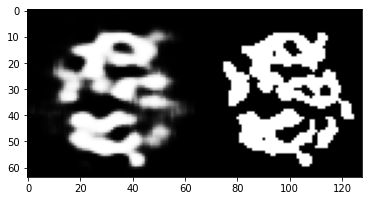

2/2 [==============================] - 0s 27ms/step
100 [0.05163605511188507, 0.8106832504272461]


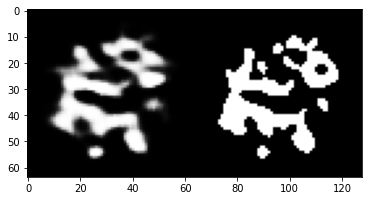

2/2 [==============================] - 0s 21ms/step
200 [0.0523078516125679, 0.8111035823822021]


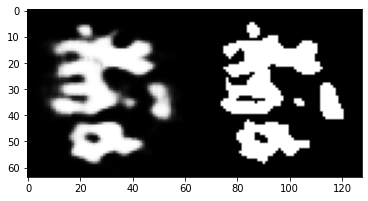

2/2 [==============================] - 0s 45ms/step
300 [0.053880784660577774, 0.807222843170166]


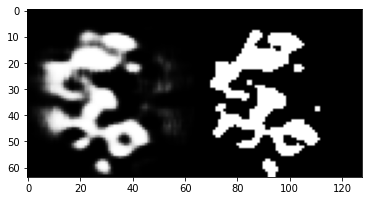

2/2 [==============================] - 0s 23ms/step
400 [0.05468231439590454, 0.8089932203292847]


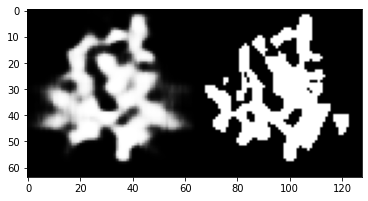

2/2 [==============================] - 0s 30ms/step
500 [0.048331063240766525, 0.8160626292228699]


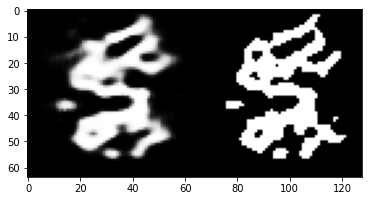

2/2 [==============================] - 0s 34ms/step
600 [0.04671438783407211, 0.815782904624939]


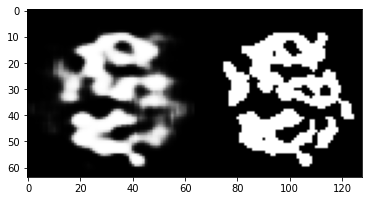

2/2 [==============================] - 0s 38ms/step
700 [0.045188892632722855, 0.8251237869262695]


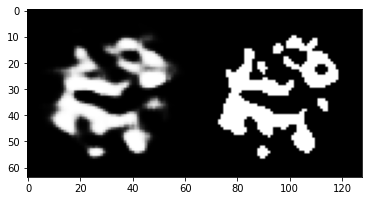

2/2 [==============================] - 0s 131ms/step
800 [0.047452423721551895, 0.8191996812820435]


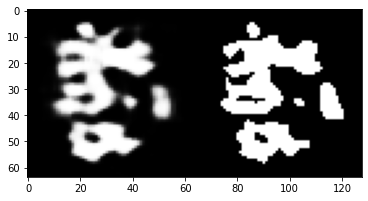

2/2 [==============================] - 0s 32ms/step
900 [0.044872965663671494, 0.8228429555892944]


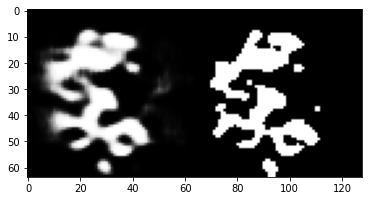

2/2 [==============================] - 0s 57ms/step
1000 [0.04795607551932335, 0.8179113864898682]


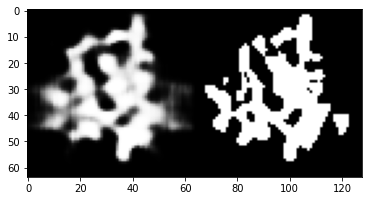

2/2 [==============================] - 0s 31ms/step
1100 [0.04504646733403206, 0.8252584338188171]


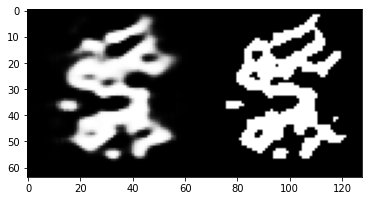

2/2 [==============================] - 0s 25ms/step
1200 [0.04588066786527634, 0.8227939605712891]


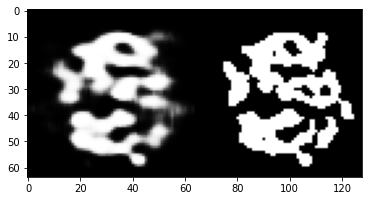

2/2 [==============================] - 0s 18ms/step
1300 [0.04334435984492302, 0.8294259309768677]


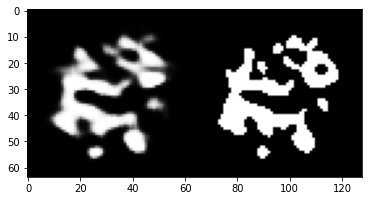

2/2 [==============================] - 0s 26ms/step
1400 [0.046972230076789856, 0.819176435470581]


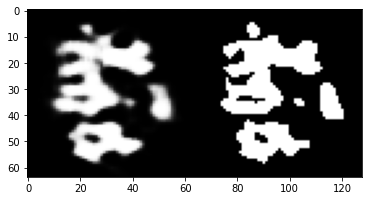

2/2 [==============================] - 0s 59ms/step
1500 [0.039192281663417816, 0.829210102558136]


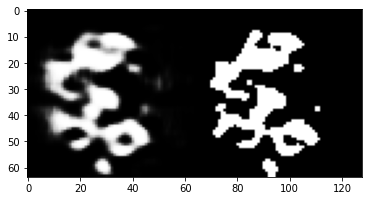

2/2 [==============================] - 0s 97ms/step
1600 [0.04967762902379036, 0.8225616216659546]


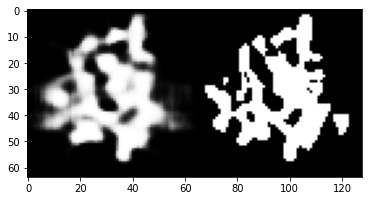

2/2 [==============================] - 0s 38ms/step
1700 [0.04477126523852348, 0.8254218101501465]


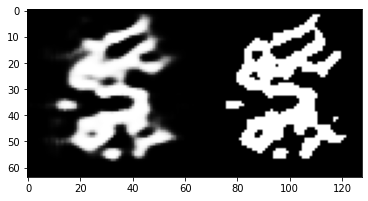

2/2 [==============================] - 0s 38ms/step
1800 [0.04237499088048935, 0.825015127658844]


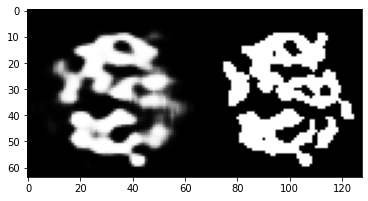

2/2 [==============================] - 0s 75ms/step
1900 [0.0374998040497303, 0.840164065361023]


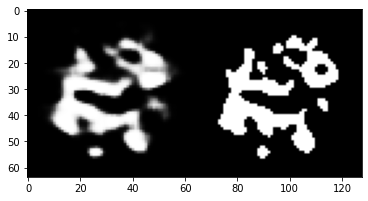

2/2 [==============================] - 0s 120ms/step
2000 [0.041378773748874664, 0.8304104804992676]


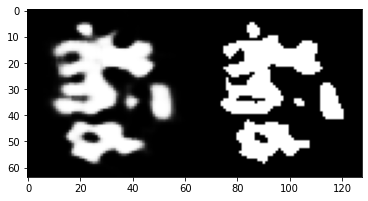

2/2 [==============================] - 0s 25ms/step
2100 [0.039129942655563354, 0.8333348631858826]


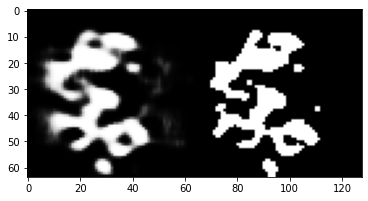

2/2 [==============================] - 0s 22ms/step
2200 [0.04182226583361626, 0.830216646194458]


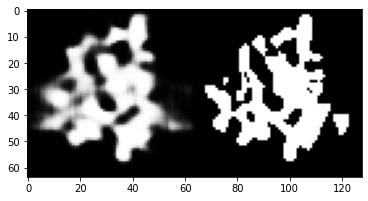

2/2 [==============================] - 0s 17ms/step
2300 [0.038673147559165955, 0.8346623778343201]


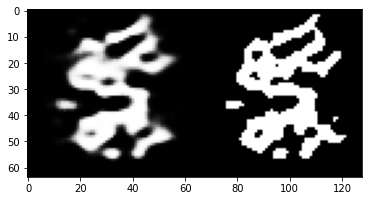

2/2 [==============================] - 0s 22ms/step
2400 [0.038406990468502045, 0.8317553400993347]


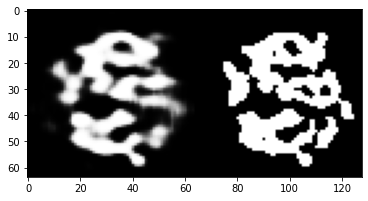

2/2 [==============================] - 0s 19ms/step
2500 [0.03416366130113602, 0.8456567525863647]


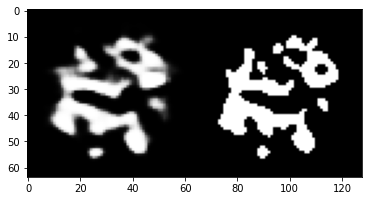

2/2 [==============================] - 0s 18ms/step
2600 [0.037059981375932693, 0.8390559554100037]


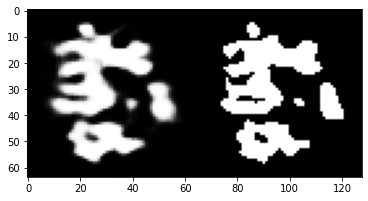

2/2 [==============================] - 0s 19ms/step
2700 [0.032489798963069916, 0.8423563241958618]


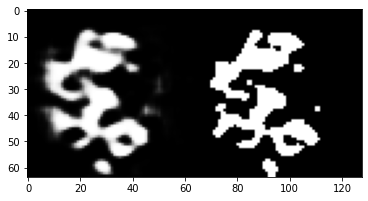

In [ ]:
# G's unet
# not use the fit. G. // train_on_batch


NUM_STEPS = 10000

# model.summary()

for step in range(NUM_STEPS):
    
    img, msk = train_img_datagen.__next__()
    
    img = np.squeeze(img)
    msk = np.argmax(msk, axis=-1).astype('float64')  # remove last channel
    # msk = np.expand_dims(msk, axis=-1).astype('float64')
    
    loss = model.train_on_batch(img, msk)  # control the way to consume MM
    
    # print(step, loss)
    
    if step % 1000 == 0:
        model.save_weights('./model_savedG.hdf5')
        
    if step % 100 == 0:
        prediction = model.predict(img,batch_size=1)
        print(step, loss)
        plt.imshow(np.concatenate((prediction[0,32,:,:], msk[0,32,:,:]), axis=1),cmap='gray')
        plt.show()
        plt.close('all')


In [23]:
# visualize

showPred = prediction
showMask = msk

(2, 64, 64, 64) (2, 64, 64, 64)
slice Num: 36


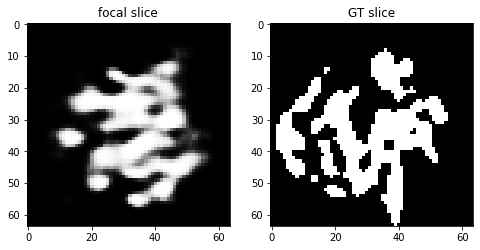

In [53]:
print(showPred.shape, showMask.shape)
n_slice = random.randint(0, showPred.shape[1])

NUM = 0
print('slice Num:', n_slice)
visusalizeIMG(n_slice, showPred[NUM,...], showMask[NUM,...])

In [75]:

# original model

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=10,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch,)


MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/model/'

model.save(MODEL_PATH + 'simple_3d' + '_10_' + '.hdf5')

Epoch 1/10
60/60 [==============================] - 16s 241ms/step - loss: 0.1922 - accuracy: 0.5265 - iou_score: 0.3524 - val_loss: 0.2225 - val_accuracy: 0.8921 - val_iou_score: 0.5184
Epoch 2/10
60/60 [==============================] - 14s 235ms/step - loss: -0.4229 - accuracy: 0.8762 - iou_score: 0.6317 - val_loss: 0.6235 - val_accuracy: 0.8849 - val_iou_score: 0.4426
Epoch 3/10
60/60 [==============================] - 14s 233ms/step - loss: -0.4444 - accuracy: 0.8767 - iou_score: 0.6346 - val_loss: 0.6519 - val_accuracy: 0.8880 - val_iou_score: 0.4446
Epoch 4/10
60/60 [==============================] - 14s 235ms/step - loss: -0.4498 - accuracy: 0.8760 - iou_score: 0.6346 - val_loss: 0.6669 - val_accuracy: 0.8840 - val_iou_score: 0.4421
Epoch 5/10
60/60 [==============================] - 14s 233ms/step - loss: -0.4528 - accuracy: 0.8769 - iou_score: 0.6355 - val_loss: 0.6572 - val_accuracy: 0.8881 - val_iou_score: 0.4448
Epoch 6/10
60/60 [==============================] - 14s 234ms

### visualize the training process

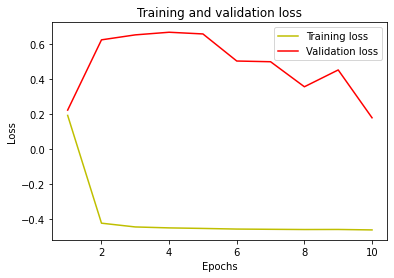

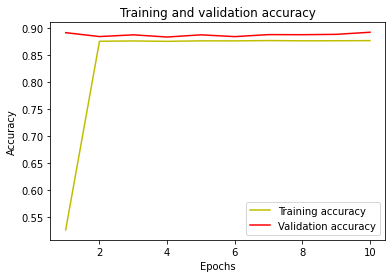

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### predict the test dataset of single image

In [6]:
# load in the model

MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/model/'

from keras.models import load_model
my_model = load_model(MODEL_PATH + 'simple_3d' + '_10_' + '.hdf5', compile=False)

In [7]:
# for prediction verify IoU

from keras.metrics import MeanIoU

batch_size = 4  # prediction batch

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                              test_msk_dir, test_msk_list, batch_size)

In [8]:
# verify the generator

test_image_batch, test_mask_batch = test_img_datagen.__next__()  
print('before:', test_mask_batch.shape)
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) # convert onehot back to integer
print('after:', test_mask_batch_argmax.shape)

before: (4, 64, 64, 64, 2)
after: (4, 64, 64, 64)


In [9]:
# predict

test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

1/1 [==============================] - 0s 20ms/step


In [10]:
# n_classes = 2

n_classesG = 1
IOU_keras = MeanIoU(num_classes=n_classesG)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5251244


### predict the test dataset of multiple image

In [11]:
img_num = 15  # the name in test dataset

test_img = np.load(DATA_PATH + '/test/images/image_'+str(img_num)+'.npy')

test_mask = np.load(DATA_PATH + '/test/masks/mask_'+str(img_num)+'.npy')
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 1s 549ms/step


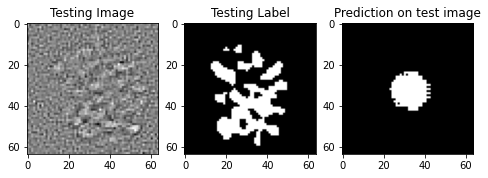

In [18]:
# visualize in x direction

n_slice = 25

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[n_slice,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[n_slice,:,:], cmap='gray')
plt.show()

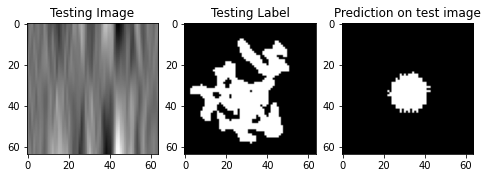

In [19]:
# visualize in y direction

n_slice = 25

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,n_slice,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,n_slice,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,n_slice,:], cmap='gray')
plt.show()